In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

In [2]:
pf_data <- read_csv("final_data.csv") |>
        mutate(max_portfolio_return_name = as_factor(max_portfolio_return_name))|>
        select(-year) |>
        as_tibble()

head(pf_data)

Rows: 25 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): max_portfolio_return_name
dbl (5): year, annual_inflation, real_gdp_growth_rate_percentage, annual_une...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_value,max_portfolio_return_name
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2.337690,4.4,4.950000,22.37,60/40_portfolio_return_percentage
1.552279,4.5,4.508333,18.26,growth_portfolio_return_percentage
2.188027,4.8,4.216667,20.79,growth_portfolio_return_percentage
3.376857,4.1,3.991667,4.77,income_portfolio_return_percentage
2.826171,1.0,4.733333,3.38,income_portfolio_return_percentage
1.586032,1.7,5.775000,4.77,income_portfolio_return_percentage


In [8]:
#num_obs <- nrow(pf_data)

#pf_data |>
#group_by(max_portfolio_return_value) |>
#summarize(count = n(), percentage = n() / num_obs * 100)

#performing rebalancing:
install.packages("themis")
library (themis)

ups_recipe <- recipe(max_portfolio_return_value ~ ., data = pf_data) |>
step_upsample(max_portfolio_return_name, over_ratio = 1, skip = FALSE) |>
prep()
ups_recipe

upsampled_portfolio <- bake(ups_recipe, pf_data)

upsampled_portfolio |>
group_by(max_portfolio_return_name) |>
summarize(n = n())
print(upsampled_portfolio)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4

Training data contained 25 data points and no missing data.

Operations:

Up-sampling based on max_portfolio_return_name [trained]

max_portfolio_return_name,n
<fct>,<int>
60/40_portfolio_return_percentage,15
growth_portfolio_return_percentage,15
income_portfolio_return_percentage,15
40/60_portfolio_return_percentage,15


# A tibble: 60 × 5
   annual_inflation real_gdp_growth_rate_perc… annual_unemploy… max_portfolio_r…
              <dbl>                      <dbl>            <dbl> <fct>           
 1            1.62                         2.3             6.17 60/40_portfolio…
 2            1.26                         1.7             4.87 60/40_portfolio…
 3            0.119                        2.7             5.29 60/40_portfolio…
 4            1.62                         2.3             6.17 60/40_portfolio…
 5            2.34                         4.4             4.95 60/40_portfolio…
 6            1.26                         1.7             4.87 60/40_portfolio…
 7            1.26                         1.7             4.87 60/40_portfolio…
 8            0.119                        2.7             5.29 60/40_portfolio…
 9            0.119                        2.7             5.29 60/40_portfolio…
10            2.34                         4.4             4.95 60/40_portfolio…
# … with 

In [23]:
?initial_split

initial_split {rsample},R Documentation
data,A data frame.
prop,The proportion of data to be retained for modeling/analysis.
strata,"A variable in data (single character or name) used to conduct stratified sampling. When not NULL, each resample is created within the stratification variable. Numeric strata are binned into quartiles."
breaks,A single number giving the number of bins desired to stratify a numeric stratification variable.
pool,A proportion of data used to determine if a particular group is too small and should be pooled into another group. We do not recommend decreasing this argument below its default of 0.1 because of the dangers of stratifying groups that are too small.
...,Not currently used.
lag,A value to include a lag between the assessment and analysis set. This is useful if lagged predictors will be used during training and testing.
x,An rsplit object produced by initial_split() or initial_time_split().


In [22]:
?step_upsample

step_upsample {themis},R Documentation
recipe,A recipe object. The step will be added to the sequence of operations for this recipe.
...,"One or more selector functions to choose which variable is used to sample the data. See selections() for more details. The selection should result in single factor variable. For the tidy method, these are not currently used."
over_ratio,A numeric value for the ratio of the majority-to-minority frequencies. The default value (1) means that all other levels are sampled up to have the same frequency as the most occurring level. A value of 0.5 would mean that the minority levels will have (at most) (approximately) half as many rows than the majority level.
ratio,Deprecated argument; same as over_ratio.
role,Not used by this step since no new variables are created.
trained,A logical to indicate if the quantities for preprocessing have been estimated.
column,A character string of the variable name that will be populated (eventually) by the ... selectors.
target,An integer that will be used to subsample. This should not be set by the user and will be populated by prep.
skip,"A logical. Should the step be skipped when the recipe is baked by bake()? While all operations are baked when prep() is run, some operations may not be able to be conducted on new data (e.g. processing the outcome variable(s)). Care should be taken when using skip = TRUE as it may affect the computations for subsequent operations."
seed,An integer that will be used as the seed when upsampling.


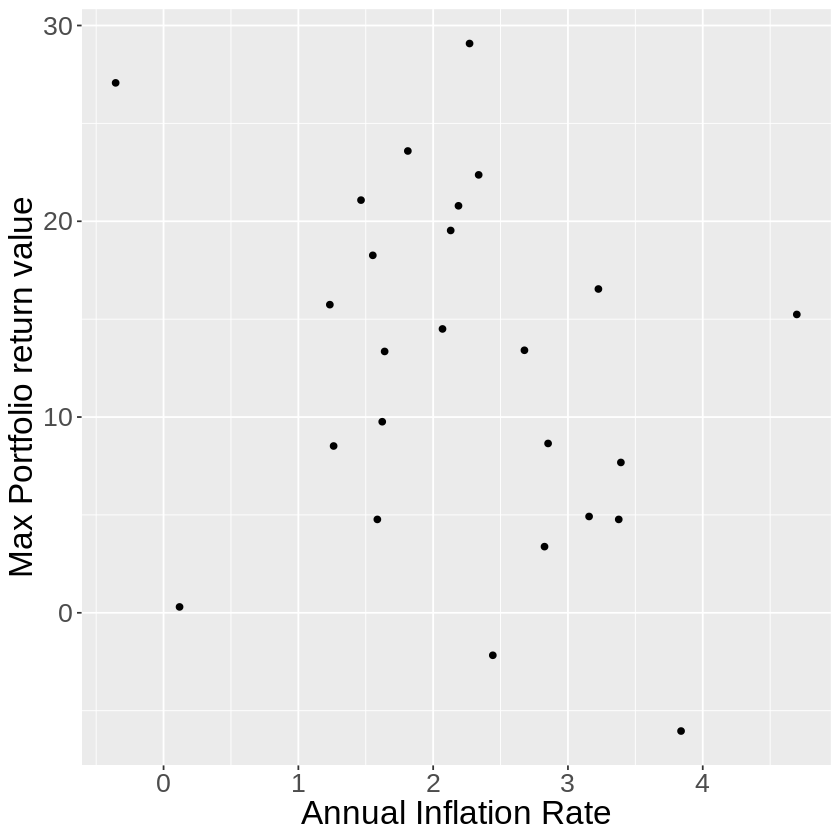

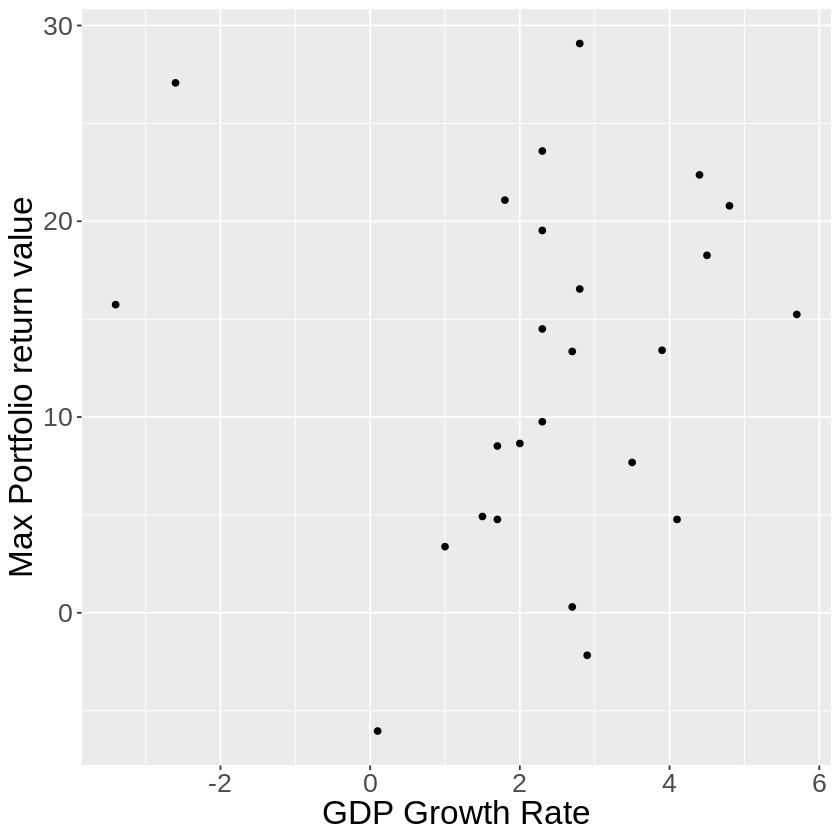

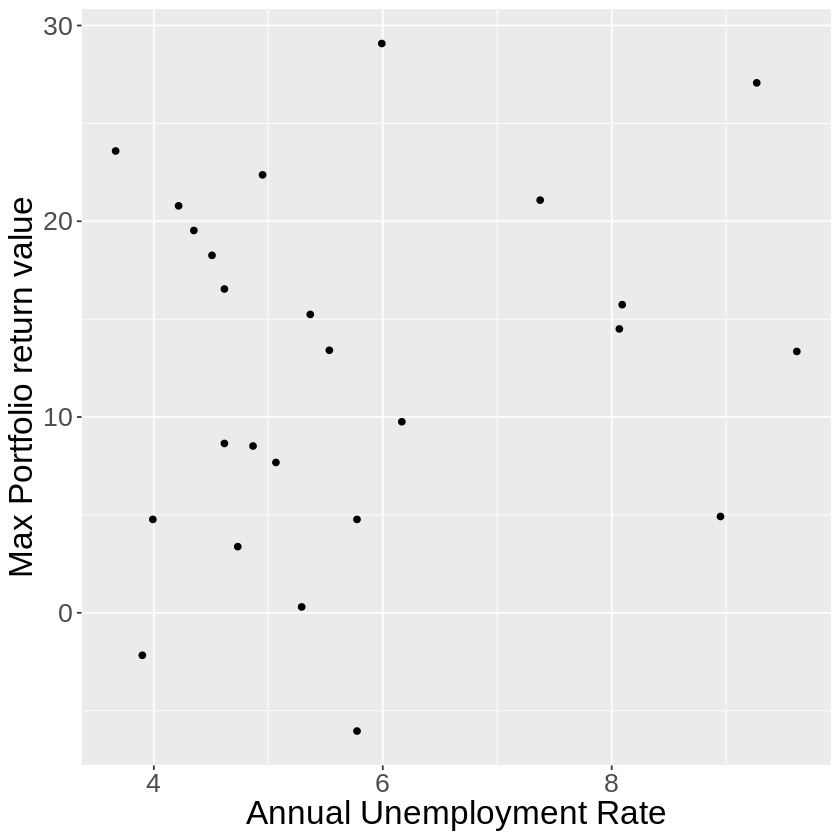

In [9]:
pf_inf_plot <- pf_data |>
        ggplot(aes(x = annual_inflation, y = max_portfolio_return_value)) +
        geom_point() +
        labs(x = "Annual Inflation Rate", y = "Max Portfolio return value") +
        theme(text = element_text(size = 20))

pf_gdp_plot <- pf_data |>
        ggplot(aes(x = real_gdp_growth_rate_percentage, y = max_portfolio_return_value)) +
        geom_point() +
        labs(x = "GDP Growth Rate", y = "Max Portfolio return value") +
        theme(text = element_text(size = 20))

pf_une_plot <- pf_data |>
        ggplot(aes(x = annual_unemployment_rate, y = max_portfolio_return_value)) +
        geom_point() +
        labs(x = "Annual Unemployment Rate", y = "Max Portfolio return value") +
        theme(text = element_text(size = 20))

pf_inf_plot
pf_gdp_plot
pf_une_plot

In [21]:
upsampled_portfolio

annual_inflation,real_gdp_growth_rate_percentage,annual_unemployment_rate,max_portfolio_return_name,max_portfolio_return_value
<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1.6222230,2.3,6.166667,60/40_portfolio_return_percentage,9.76
1.2615832,1.7,4.866667,60/40_portfolio_return_percentage,8.52
0.1186271,2.7,5.291667,60/40_portfolio_return_percentage,0.30
⋮,⋮,⋮,⋮,⋮
3.156842,1.5,8.95,40/60_portfolio_return_percentage,4.92
3.156842,1.5,8.95,40/60_portfolio_return_percentage,4.92
3.156842,1.5,8.95,40/60_portfolio_return_percentage,4.92


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



Linear Regression Model Specification (regression)

Computational engine: lm 

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          4


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                                                (Intercept)  
                                                    -4.8928  
                                           annual_inflation  
                                                     0.7139  
                            real_gdp_growth_rate_percentage  
                                                     1.4386  
                                   annual_unemployment_rate  
                                                     1.7601  
max_portfolio_return_namegrowth_portfolio_return_percentage  
                                                     5.4848  
max_portfolio_r

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
                                                (Intercept)  
                                                    -4.8928  
                                           annual_inflation  
                                                     0.7139  
                            real_gdp_growth_rate_percentage  
                                                     1.4386  
                                   annual_unemployment_rate  
                                                     1.7601  
max_portfolio_return_namegrowth_portfolio_return_percentage  
                                                     5.4848  
max_portfolio_r

[1] 5.493925

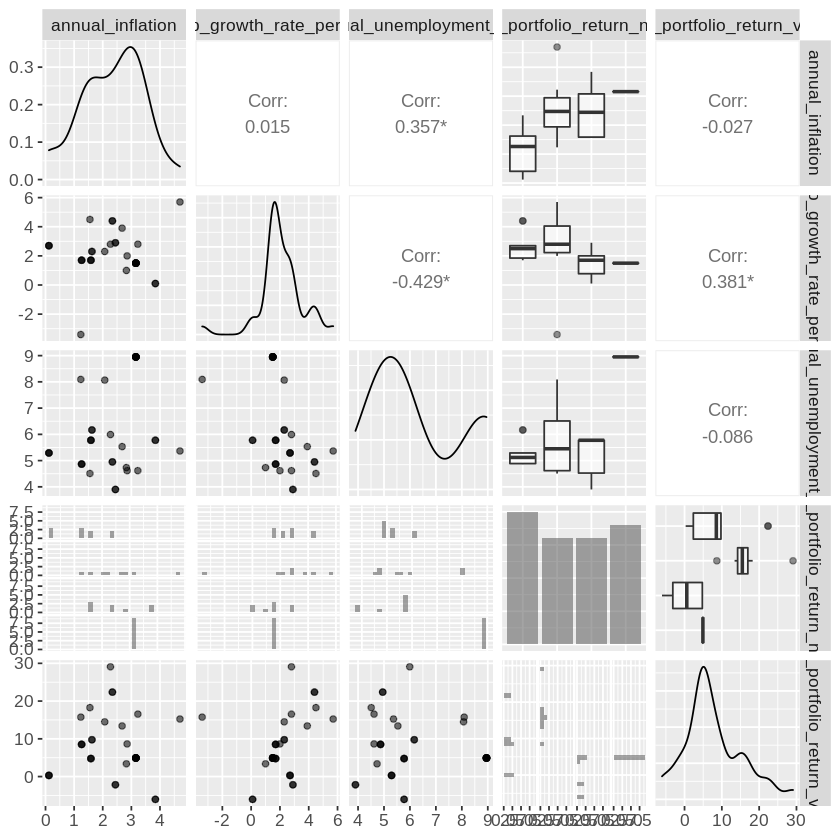

In [27]:
set.seed(9999)

pf_split <- initial_split(upsampled_portfolio, prop = 0.6, strata = max_portfolio_return_value, breaks = 3)
pf_training <- training(pf_split)
pf_testing <- testing(pf_split)

pf_t_plot <- pf_training|>
    ggpairs(mapping=aes(alpha=0.05))+
    theme(text=element_text(size=13))
pf_t_plot

lm_specr <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

pf_reciper <- recipe(max_portfolio_return_value ~ ., data=pf_training)

print(lm_specr)
print(pf_reciper)

pf_fit <- workflow()|>
    add_recipe(pf_reciper)|>
    add_model(lm_specr)|>
    fit(data=pf_training)
pf_fit

pf_fit

pf_rmsper <- pf_fit|>
    predict(pf_testing)|>
    bind_cols(pf_testing)|>
    metrics(truth=max_portfolio_return_value, estimate=.pred)|>
    filter(.metric=="rmse")|>
    select(.estimate)|>
    pull()
pf_rmsper

In [11]:
nrow(pf_training)

[1] 52

In [28]:
#Requires more data

set.seed(9999)

# your code here
knn_recipe <- recipe(max_portfolio_return_value ~ ., data=pf_training)|>
                step_center(all_predictors())|>
                step_scale(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine("kknn")|>
            set_mode("regression")

set_vfold <- vfold_cv(pf_training, v = 5, strata = max_portfolio_return_value)

knn_workflow <- workflow()|>
                add_recipe(knn_recipe)|>
                add_model(knn_spec)

gridvals <- tibble(neighbors=seq(1,12))

knn_results <- knn_workflow |>
                tune_grid(resample=set_vfold, grid=gridvals)|>
                collect_metrics()

kmin <- knn_results |>
        filter(.metric == "rmse")|>
        filter(mean == min(mean))|>
        pull(neighbors)

pf_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                set_engine("kknn")|>
                set_mode("regression")

pf_fit2 <- workflow()|>
    add_recipe(knn_recipe)|>
    add_model(pf_spec)|>
    fit(data = pf_training)

knn_rmspe <- pf_fit |>
    predict(pf_testing)|>
    bind_cols(pf_testing)|>
    metrics(truth=max_portfolio_return_value, estimate = .pred)|>
    filter(.metric == "rmse")|>
    pull(.estimate)

knn_rmspe

#might try upsampling: 5 fold require at least 100 data points. Our training is 18. Copy Christian's codes for upsampling.

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
• Stratification will use 1 breaks instead.”
Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”
x Fold1: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold2: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold3: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold4: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

x Fold5: preprocessor 1/1:
  Error in `check_type()`:
  ! All columns selected for the step should be numeric

Warning message:
“All models failed. Run `show_notes(.Last.tune.result)` for more information.”


ERROR: [1m[33mError[39m in [1m[1m`estimate_tune_results()`:[22m
[33m![39m All of the models failed. See the .notes column.
